In [45]:
import json
import pandas as pd
import numpy as np
import plotly.express as px
import re
import matplotlib.pyplot as plt
import tensorflow
import nltk
import gensim
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [9]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kipkorir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kipkorir\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kipkorir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# loading data to pandas dataframe
df = pd.read_json("CETM47-22_23-AS2-Data.json")
df.head()

,text,date,label,id,label_name
0,The {@Clinton LumberKings@} beat the {@Cedar R...,2019-09-08,4,1170516324419866624,sports_&_gaming
1,I would rather hear Eli Gold announce this Aub...,2019-09-08,4,1170516440690176006,sports_&_gaming
2,"Someone take my phone away, I’m trying to not ...",2019-09-08,4,1170516543387709440,sports_&_gaming
3,"A year ago, Louisville struggled to beat an FC...",2019-09-08,4,1170516620466429953,sports_&_gaming
4,Anyone know why the #Dodgers #Orioles game nex...,2019-09-08,4,1170516711411310592,sports_&_gaming


In [22]:
# df.describe()
print("Count of label wise values: \n", df.label_name.value_counts())

print(df.isnull()) #.count())

Count of label wise values: 
 pop_culture                 2512
sports_&_gaming             2291
daily_life                   883
science_&_technology         326
business_&_entrepreneurs     287
arts_&_culture               144
Name: label_name, dtype: int64
       text   date  label     id  label_name
0     False  False  False  False       False
1     False  False  False  False       False
2     False  False  False  False       False
3     False  False  False  False       False
4     False  False  False  False       False
...     ...    ...    ...    ...         ...
6438  False  False  False  False       False
6439  False  False  False  False       False
6440  False  False  False  False       False
6441  False  False  False  False       False
6442  False  False  False  False       False

[6443 rows x 5 columns]


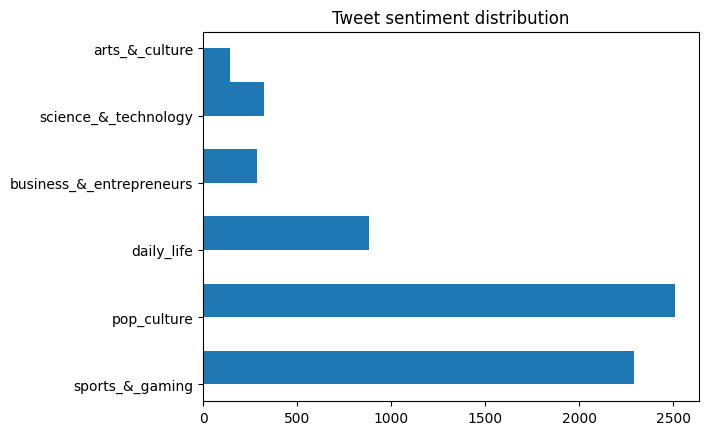

In [21]:
plt.hist(df.label_name, orientation='horizontal')
plt.title("Tweet sentiment distribution")
plt.show()

In [23]:
import string
# function to clean tweets
def data_cleaning(data):
    cleaned_data = []
    fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
    fillerword_reg= "bye[.,]|so[.,]|yeah[.,]|okay[.,]|um[.,]|uh[.,]|mmm[.,]|ahan[.,]|uh[.,]|huh[.,]|ahm[.,]|oh[.,]|sooo[.,]|uh[.,]|huh[.,]|yeh[.,]|yah[.,]|hmm[.,]"
    STOPWORDS = set(stopwords.words('english'))
    remove=["doesn't","not","nor","neither","isn't","hadn't","mightn't","needn't","wasn't"]
    for i in remove:
        STOPWORDS.discard(i)
    
    STOPWORDS.add(fillerWord)  
    for i in range(len(data)):
        tweet = re.sub("#", "", data[i])#extracting hashtags
        tweet = re.sub(r'^https?:\/\/.*[\r\n]*', '',tweet, flags=re.MULTILINE)#extracting links
        html=re.compile(r'<.*?>')#extracting html tags
        tweet =html.sub(r"", tweet)
        #extracting symbols and characters
        tweet=re.sub(r'@\w+',"",tweet)
        tweet=re.sub(r'#\w+',"",tweet) 
        tweet=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) 
        punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        tweet.rstrip(string.punctuation)
        tweet=re.sub('[^A-Za-z\s]+',"", tweet)
        tweet = tweet.lower()
        tweet = tweet.split()
        #Lemmatization to normalise text
        tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in STOPWORDS]
        tweet = ' '.join(tweet)
        filler=re.compile(fillerword_reg)
        tweet=filler.sub("",tweet)
        cleaned_data.append(tweet)
    return cleaned_data

In [24]:
#Preprocessing and cleaning train data
text_data=df['text'].tolist()
processed_text=data_cleaning(text_data)

cleaned_tweet =pd.DataFrame(processed_text)
df['cleaned_tweet']=cleaned_tweet


df.head()

,text,date,label,id,label_name,CleanedTweet
0,The {@Clinton LumberKings@} beat the {@Cedar R...,2019-09-08,4,1170516324419866624,sports_&_gaming,lumberkings beat rapid kernel game western div...
1,I would rather hear Eli Gold announce this Aub...,2019-09-08,4,1170516440690176006,sports_&_gaming,would rather hear eli gold announce auburn gam...
2,"Someone take my phone away, I’m trying to not ...",2019-09-08,4,1170516543387709440,sports_&_gaming,someone take phone away im trying not look bla...
3,"A year ago, Louisville struggled to beat an FC...",2019-09-08,4,1170516620466429953,sports_&_gaming,year ago louisville struggled beat fcs opponen...
4,Anyone know why the #Dodgers #Orioles game nex...,2019-09-08,4,1170516711411310592,sports_&_gaming,anyone know dodger oriole game next thursday f...


In [38]:
# Seperating tweet and class labels
X_train = df.cleaned_tweet
Y_train = df.label

x_test = df.cleaned_tweet
y_test = df.label

print(X_train.shape)
print(Y_train.shape)

(6443,)
(6443,)


In [39]:
# Convert tweets to a matrix of token counts.
vectorizer = CountVectorizer(max_features= 1000, min_df = 3, max_df = 0.6)
# fit the model for training data
X_train_data = vectorizer.fit_transform(X_train)
print(X_train_data.shape)
x_test_data = vectorizer.fit_transform(x_test)

transformer = TfidfTransformer()
X_train_data = transformer.fit_transform(X_train_data).toarray()

print(X_train_data.shape)

(6443, 1000)
(6443, 1000)


In [46]:
#  Training and testing naive bayes classifier
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train_data, Y_train, test_size=0.15,random_state = 15)

modelNB = MultinomialNB()
modelNB.fit(X1_train,y1_train)

y_pred = modelNB.predict(X1_test)
print("Naive Bayes:", metrics.accuracy_score(y1_test, y_pred))

Naive Bayes: 0.7414684591520165
